# Lab 09: Multi-Perspective Customer Segmentation

**Learning Objectives:**
1. Organize features into business-driven perspectives
2. Apply optimal K selection separately to perspectives
3. **Merge perspectives using HC on centroids**
4. Profile and characterize merged segments
5. Interpret feature importance via R² decomposition
6. Translate clusters into business personas

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Set plotting style
sns.set()
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Cell 4: Load preprocessed data
df = pd.read_csv('../data/data_preprocessed.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (8817, 35)


,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376


In [3]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = ['income',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

non_metric_features = df.columns[df.columns.str.startswith('oh_')].tolist() 

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features) ]

print("Metric features:", metric_features)
print("Non-metric features:", non_metric_features)
print("Unused features:", unused_features)

Metric features: ['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping', 'per_net_purchase', 'spent_online']
Non-metric features: ['oh_education_2nd Cycle', 'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD', 'oh_status_Married', 'oh_status_Single', 'oh_status_Together', 'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0', 'oh_description_Kind of OK', 'oh_description_Meh...', 'oh_description_OK nice!', 'oh_description_Take my money!!']
Unused features: ['age', 'mnt', 'dependents', 'gender', 'education', 'status', 'description', 'birth_year', 'PC0', 'PC1', 'PC2']


# Before we proceed

- Preprocessing steps already done:
    - Dealt with inconsistencies (duplicates, dataypes)
    - Scaling
    - Univariate outlier removal
    - Dropped redudant features (`age`) 

- Important extra-steps:
    - Consider dropping/transforming the variable `rcn`. Why?
    - Multivariate outlier removal   

In [4]:
metric_features.remove('rcn')  # Removing 'rcn' as discussed previously

In [5]:
# Cell 7: Remove outliers using DBSCAN
# Based on the hyperparameters that will be found in lab10
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])

# Check outlier count
outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count[-1]}")
print(f"Core customers: {outlier_count[0]}")

# Save outliers for later classification
df_out = df[dbscan_labels == -1].copy()

# Filter to core customers only
df = df[dbscan_labels != -1].copy()
print(f"\nWorking with {len(df):,} core customers")
print(f"Outliers saved for later: {len(df_out)}")

DBSCAN results: Counter({0: 8792, -1: 25})
Outliers detected: 25
Core customers: 8792

Working with 8,792 core customers
Outliers saved for later: 25


# Defining the perspectives

- **Multi-Perspective Segmentation:** Different stakeholders need different analytical views
    - **Marketing Team** wants behavioral segments (how customers shop)
    - **Product Team** wants preference segments (what customers buy)
    - **Executive Team** wants ONE unified segmentation strategy


In [6]:
# Cell 5: Define feature perspectives

# Behavioral features (how customers shop)
demographic_features = [
    'income',
    'frq',
    'per_net_purchase',
    'spent_online'
]

# Product Preference features (what customers buy)
preference_features = [
    'clothes',
    'kitchen',
    'small_appliances',
    'toys',
    'house_keeping'
]

# Combined metric features (for final analysis)
metric_features = demographic_features + preference_features

print("Demographic features:", demographic_features)
print("Product Preference features:", preference_features)
print("Total metric features:", len(metric_features))

Demographic features: ['income', 'frq', 'per_net_purchase', 'spent_online']
Product Preference features: ['clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping']
Total metric features: 9


# Clustering for each perspective 

##### For each clustering perspective we need to define 

- Clustering algorithm 
- Number of clusters 

## Demographic perspective

In [7]:
df_dem = df[demographic_features].copy()
df_dem

,income,frq,per_net_purchase,spent_online
0,0.743162,1.191605,-1.257560,0.522055
1,1.559488,1.100011,-1.798649,-0.237578
2,-1.548542,-0.823463,0.906799,-0.904191
3,0.845528,0.550447,-0.391816,0.785568
4,0.782435,1.008417,-0.445925,1.237135
...,...,...,...,...
8812,0.618993,0.458853,0.257492,1.275517
8813,0.874744,0.733635,0.690363,1.865248
8814,-0.455617,-0.731869,1.556107,-0.801266
8815,-0.596155,0.825229,-0.608252,0.801051


In [8]:
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)


In [9]:
hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [10]:
# Cell 3: Helper functions from Labs 09-12

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.
    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.
    
    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    return ss


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns:
    float: The between-group sum of squares of the DataFrame.
    """
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))))
    
    ssb = np.sum(ssb_i)
    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.
    
    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats + [label_col]
    df_k = df[feats_label].groupby(by=label_col).apply(
        lambda col: get_ss(col, feats),
        include_groups=False
    )
    return df_k.sum()


def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.
    
    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """
    df_sst_ = get_ss(df, feats)  # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)  # get ss within
    df_ssb_ = df_sst_ - df_ssw_  # get ss between
    # r2 = ssb/sst
    return (df_ssb_ / df_sst_)


def get_r2_scores(df, feats, clusterer, min_k=1, max_k=9):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df,
                               pd.Series(labels, name='labels', index=df.index)], axis=1)
        r2_clust[n] = get_rsq(df_concat, feats, 'labels')
    return r2_clust

In [11]:
r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_dem, demographic_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem,                 # data
        demographic_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )


c:\Users\2004l\anaconda3\envs\Fall2526\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [12]:
r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df

,kmeans,complete,average,single,ward
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.571684,0.476406,0.068414,0.001028,0.550334
3,0.679349,0.527070,0.583720,0.001682,0.638016
4,0.756784,0.668176,0.585884,0.002605,0.712994
5,0.789384,0.708727,0.664679,0.003780,0.753292
6,0.819565,0.757008,0.665216,0.004541,0.781625
7,0.839166,0.770829,0.755694,0.004951,0.808584
8,0.854622,0.773782,0.757069,0.005151,0.828779


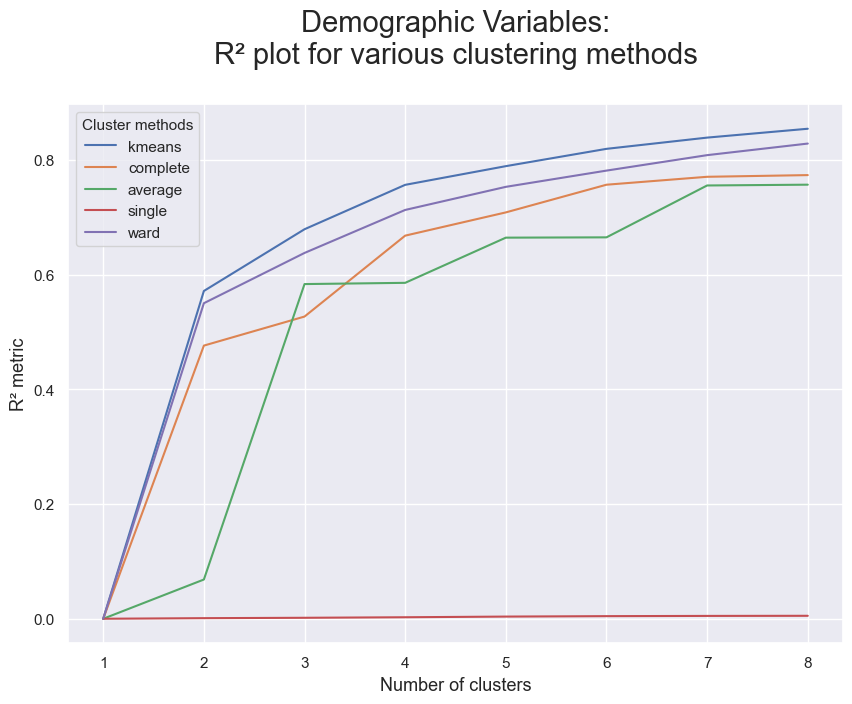

In [13]:
# Visualizing the R² scores for each cluster solution on demographic variables
r2_scores_df.plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

## Preferences / product perspective

In [ ]:
# ===========================================================
# TODO IN CLASS EXERCISE
# Apply the same procedure to the preference features
# ===========================================================

df_prf = None

In [2]:
r2_scores_pref = {}


# Final solutions 

In [5]:
# ===========================================================
# TODO IN CLASS EXERCISE
# Apply the final clustering solution to the demographic features
# ===========================================================

kmeans_demo = KMeans(
    n_clusters=None,
    init='k-means++',
    n_init=20,
    random_state=42
)

In [12]:
df['demographic_cluster'] = None

In [6]:
# ===========================================================
# TODO IN CLASS EXERCISE
# Apply the final clustering solution to the preference features    
# ===========================================================

kmeans_pref = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)

In [10]:
df['product_cluster'] = None

In [13]:
print("Clustering complete!")
print(f"Behavioral clusters: {df['demographic_cluster'].nunique()}")
print(f"Preference clusters: {df['product_cluster'].nunique()}")

Clustering complete!
Behavioral clusters: 0
Preference clusters: 0


#### How many combinations of clusters we would have ? 

In [68]:
crosstab = pd.crosstab(df['demographic_cluster'], df['product_cluster'])
crosstab

product_cluster,0,1,2
demographic_cluster,,,
0,640,1330,208
1,1460,1160,1013
2,1231,386,290
3,247,707,43


#### Are these 12 clusters balanced ? 

#### Are we finished ? 

. 

. 

. 

.


# Merge clusters

#### Apply Hierarchical Clustering on cluster centroids

In [15]:
# Cell 16: Calculate centroids for each combination
df_centroids = df.groupby(['demographic_cluster', 'product_cluster'])[metric_features].mean()
df_centroids

,,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
demographic_cluster,product_cluster,,,,,,,,,,


In [73]:
print(f"\nCentroids shape: {df_centroids.shape}")


Centroids shape: (12, 9)


#### We will assume ward linkage 

#### But need to decide the number of final clusters 

In [119]:
# Fit hierarchical clustering with distance tracking
hclust = AgglomerativeClustering(
    linkage='ward',
    metric='euclidean',
    distance_threshold=0,
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

# Build linkage matrix for dendrogram
# (Adapted from scikit-learn documentation)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # Leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([
    hclust.children_,
    hclust.distances_,
    counts
]).astype(float)

print("Linkage matrix ready for dendrogram!")

Linkage matrix ready for dendrogram!


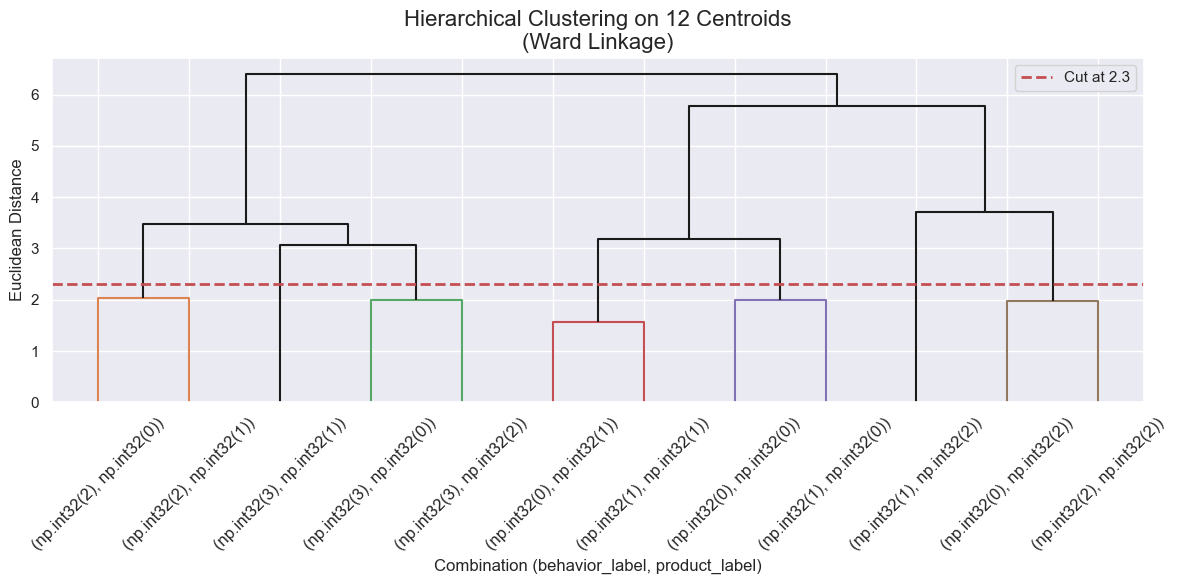

In [75]:
# Cell 18: Plot dendrogram with cutting options
fig = plt.figure(figsize=(12, 6))

# Potential cutting heights to consider
y_threshold = 2.3  # Can adjust this!

dendrogram(
    linkage_matrix,
    labels=df_centroids.index,
    color_threshold=y_threshold,
    above_threshold_color='k'
)

plt.axhline(y=y_threshold, color='r', linestyle='--', linewidth=2, label=f'Cut at {y_threshold}')

plt.title(f'Hierarchical Clustering on 12 Centroids\n(Ward Linkage)', fontsize=16)
plt.xlabel('Combination (behavior_label, product_label)')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Apply the HC with *n* clusters on the centroids 

In [16]:
# ===========================================================
# TODO IN CLASS EXERCISE
# Apply the final HC solution to the combined centroids 
# ===========================================================

n_final_clusters = None

hclust_final = AgglomerativeClustering(
    linkage='ward',
    n_clusters=n_final_clusters
)


In [17]:
# Add to centroids dataframe
df_centroids['merged_labels'] = None

In [19]:
cluster_mapper = df_centroids['merged_labels'].to_dict()
cluster_mapper  

{}

In [ ]:
# Cell 21: Map merged labels back to all customers

df['merged_labels'] = df.apply(
    lambda row: cluster_mapper[(row['demographic_cluster'], row['product_cluster'])],
    axis=1
)
df


In [84]:
print(df['merged_labels'].value_counts().sort_index())

merged_labels
0    1617
1     290
2    2100
3    1013
4     498
5    2490
6     707
Name: count, dtype: int64


### Are the merged clusters balanced ? 

In [89]:
# Quick distinctiveness check (R²)
r2_merged = get_rsq(df, metric_features, 'merged_labels')
print(f"\nMerged clustering R²: {r2_merged:.4f}")


Merged clustering R²: 0.5972


##### How could you compare different final K merged solutions ? 

# Profiling 

## Metric features 

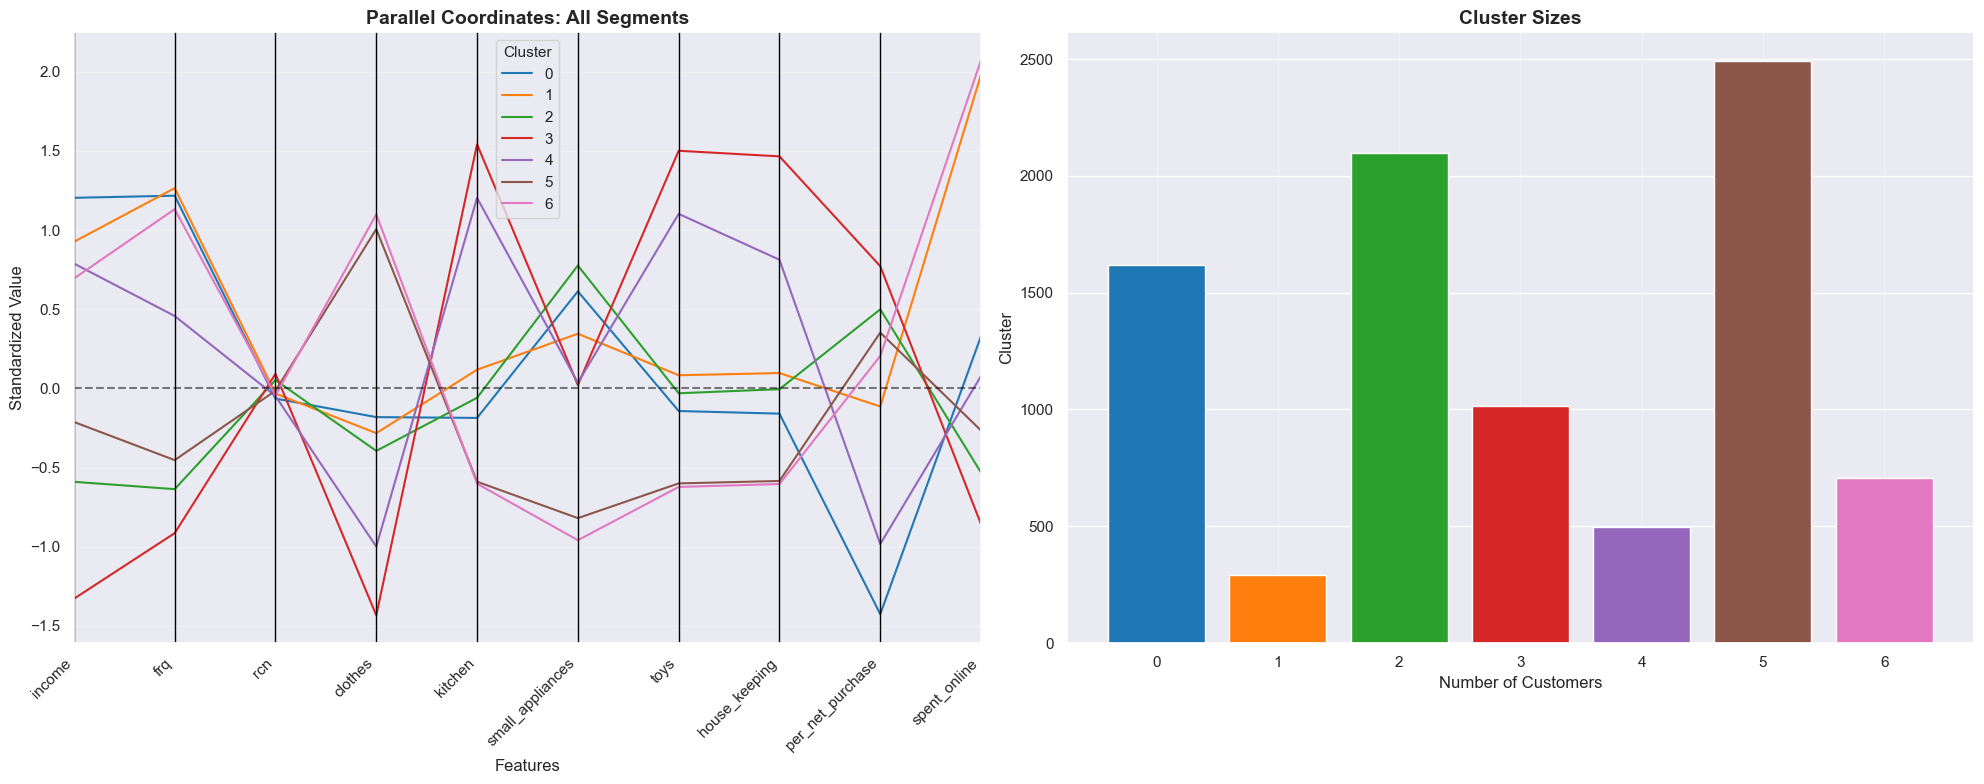

In [ ]:
# Get centroids for ALL segments
all_segments = sorted(df['merged_labels'].unique())
df_all_centroids = df.groupby('merged_labels')[metric_features].mean()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# LEFT PLOT: Parallel coordinates for all clusters
plt.sca(ax1)
pd.plotting.parallel_coordinates(
    df_all_centroids.reset_index(),
    'merged_labels',
    color=sns.color_palette('tab10', n_colors=len(all_segments)),
    ax=ax1
)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.set_title('Parallel Coordinates: All Segments', fontsize=14, fontweight='bold')
ax1.set_ylabel('Standardized Value', fontsize=12)
ax1.set_xlabel('Features', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.legend(title='Cluster', loc='best', title_fontsize=11)
ax1.grid(True, alpha=0.3)

# RIGHT PLOT: Cluster sizes (ordered by cluster number)
cluster_sizes = df['merged_labels'].value_counts().sort_index()
colors = sns.color_palette('tab10', n_colors=len(all_segments))

ax2.bar(cluster_sizes.index.astype(str), cluster_sizes.values, color=colors)
ax2.set_xlabel('Number of Customers', fontsize=12)
ax2.set_ylabel('Cluster', fontsize=12)
ax2.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### What other plot you can chose to profile the metric features ? 

In [ ]:
# ===========================================================
# TODO IN CLASS EXERCISE 
# Plot other type of visualization to profile the metric features
# ===========================================================

all_segments = sorted(df['merged_labels'].unique())
df_all_centroids = df.groupby('merged_labels')[metric_features].mean().T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    df_all_centroids,
    ax=ax1,
    # Improve the heatmap visualization here
)

ax1.set_title('Heatmap: All Segments', fontsize=14, fontweight='bold')
ax1.set_ylabel('Metric Features', fontsize=12)
ax1.set_xlabel('Clusters', fontsize=12)
ax1.grid(False)


cluster_sizes = df['merged_labels'].value_counts().sort_index()
colors = sns.color_palette('tab10', n_colors=len(all_segments))

ax2.bar(cluster_sizes.index.astype(str), cluster_sizes.values, color=colors)
ax2.set_xlabel('Number of Customers', fontsize=12)
ax2.set_ylabel('Cluster', fontsize=12)
ax2.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Non metric features 

In [ ]:
# ===========================================================
# TODO IN CLASS EXERCISE
# Improve the profiling visualization for education across segments
# ===========================================================

pd.crosstab(df['merged_labels'], df['education'], normalize='index').plot.bar(
    figsize=(10, 6)
)
plt.title("Education Level Distribution by Merged Segment", fontsize=14)
plt.xlabel("Merged Segment")
plt.ylabel("Proportion")
plt.legend(title="Education Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Feature Importances 

### Using $R^2$

Do you still remember the formula for $R^2$ calculation ? 

What proportion of each feature's total variance is explained by the cluster assignments?

In [102]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [114]:
r2_feats = r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')
r2_feats

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_36658/364241649.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
/opt/anaconda3/envs/Fall2526/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


income              0.677211
frq                 0.700756
rcn                 0.002821
clothes             0.737270
kitchen             0.516444
small_appliances    0.484307
toys                0.487774
house_keeping       0.468259
per_net_purchase    0.602483
spent_online        0.683473
dtype: float64

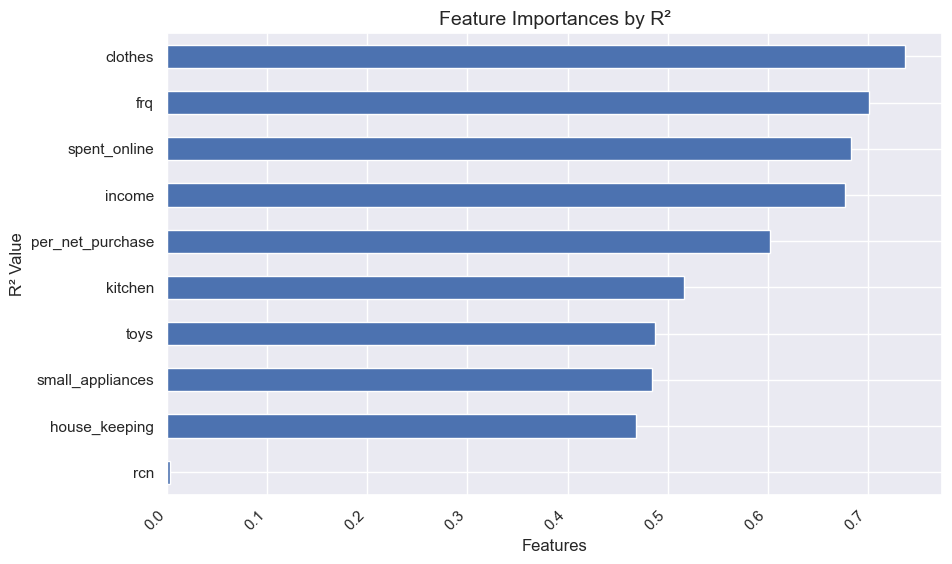

In [118]:
r2_feats.sort_values().plot.barh(figsize=(10,6))
plt.title("Feature Importances by R²", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("R² Value", fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.show()

##### So what are the features that most differentiate the segments ? 

### Decision Tree Classifier 

- Train a Decision Tree Classifier model over the cluster labels
    - Estimate the respective feature importance (Gini importance)
    - Apply the trained model to classify multivariate outliers  

# Homework 
- Build a size-value matrix for the clusters 

- Apply two clustering perspectives to your project dataset (experiment several)